In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
from datetime import datetime, timedelta
from scipy import signal
from scipy.signal import butter, filtfilt, hilbert, welch
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)
np.random.seed(42)

for dirname, _, filenames in os.walk('datasets1'):
    dataFile_quant = np.empty(len(filenames), dtype='object')
    for ii, filename in enumerate(filenames, start=0):
        dataFile_quant[ii] = (os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

featuresDF = pd.DataFrame(columns=['time', 'signal', 'inPhase', 'quadrature', 'frequency', 'amplitude', 'phase', 'snr'])
for ii in range(len(dataFile_quant)):
    df_time = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[0], dtype='float64')))[0]
    df_gen = np.transpose(np.array(pd.read_csv(dataFile_quant[ii], header= None, usecols=[1], dtype='float64')))[0]
    analytical_data = hilbert(df_gen)
    df_ip = analytical_data.real
    df_quad = analytical_data.imag
    df_freq  = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[5])
    df_amp   = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[7])
    df_phase = float(os.path.split(dataFile_quant[ii])[1].split('.csv')[0].split('_')[9])
    df_snr =   int(os.path.split(dataFile_quant[867])[1].split('.csv')[0].split('_')[11])
    featuresDF = featuresDF.append({'time': df_time,
                                    'signal': df_gen, 
                                    'inPhase': df_ip, 'quadrature': df_quad,
                                    'frequency': df_freq,
                                    'amplitude': df_amp, 'phase': df_phase,
                                    'snr': df_snr}, ignore_index=True)

#featuresDF['frequency'] = pd.to_numeric(featuresDF['frequency'])
featuresDF['snr'] = pd.to_numeric(featuresDF['snr'])
print(featuresDF.head())
print("\nData Types")
print(featuresDF.dtypes)

featuresDF.to_pickle('dataFrames/featuresDF1.p')

In [4]:
featuresDF = pd.read_pickle('dataFrames/featuresDF2.p')
print(featuresDF.head())

                                                time  \
0  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
1  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
2  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
3  [0.0, 5.0025012506253105e-09, 1.00050025012506...   
4  [0.0, 5.0025012506253105e-09, 1.00050025012506...   

                                              signal  \
0  [-0.0492304625580017, 0.0327030924190087, 0.09...   
1  [0.0527251765934891, 0.017049429611942, -0.040...   
2  [-0.0085385153947489, 0.0543612558972888, 0.07...   
3  [-0.0097275397961656, 0.0307058247435442, 0.04...   
4  [-0.0409156108864265, 0.0013119497930588, 0.00...   

                                             inPhase  \
0  [-0.04923046255800172, 0.03270309241900869, 0....   
1  [0.05272517659348908, 0.017049429611941985, -0...   
2  [-0.008538515394748905, 0.05436125589728879, 0...   
3  [-0.009727539796165604, 0.030705824743544205, ...   
4  [-0.0409156108864265, 0.0013119497930588011

In [5]:
fs = 200e6        # Simulation sampling rate (Hz)
fs_adc = 100e6    # ADC sampling rate (Hz)
t_end = 1e-5     # Simulation end time (seconds)
t = np.linspace(0, t_end, int(fs*t_end))
print("There are {} elements per sample".format(len(t)))

There are 2000 elements per sample


In [6]:
# Which Figure to show for examples
showFig = 100

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


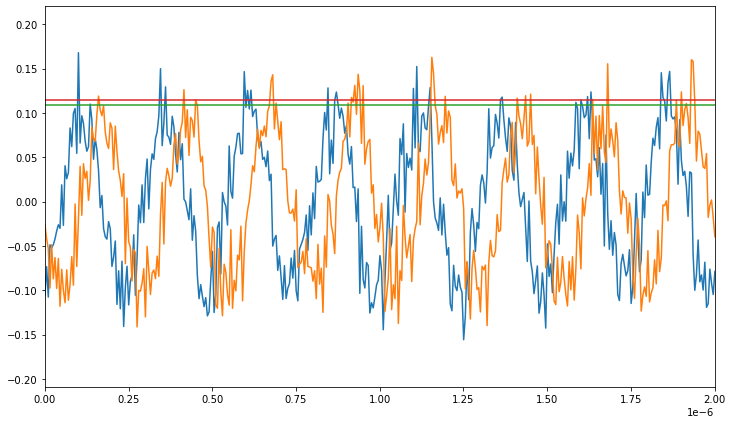

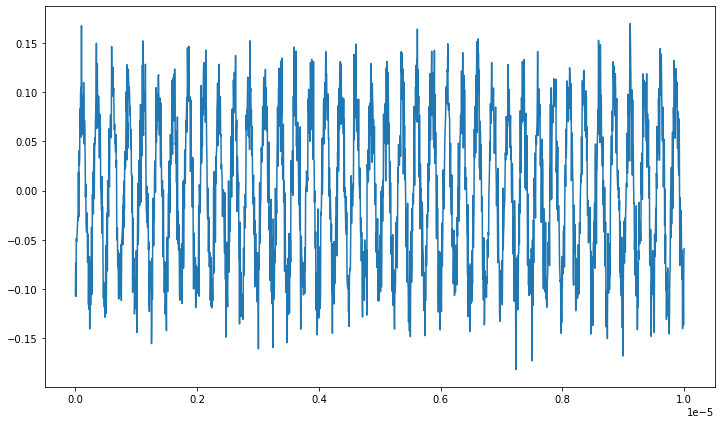

In [7]:
#IQ Data testing
def FilteredSignal(signal, fs, cutoff):
    B, A = butter(1, cutoff / (fs / 2), btype='low')
    filtered_signal = filtfilt(B, A, signal, axis=0)
    return filtered_signal

time = featuresDF.at[showFig, 'time']
testdata = featuresDF.at[showFig, 'signal']
cutoff = featuresDF.at[showFig, 'frequency']
analytical_testdata = hilbert(testdata)
amplitudeEnvelope = np.abs(analytical_testdata)
filteredSignal = FilteredSignal(amplitudeEnvelope, fs, cutoff)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.xlim(0,2e-6)
plt.plot(time, analytical_testdata.real)
plt.plot(time, analytical_testdata.imag)
plt.plot(amplitudeEnvelope)
plt.plot(filteredSignal)

plt.figure(figsize=(12,7))
plt.plot(time, testdata)

In [8]:
iq_sig = featuresDF.at[showFig, 'inPhase']*np.cos(2*np.pi*fs*t) - featuresDF.at[showFig, 'quadrature']*np.sin(2*np.pi*fs*t)

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


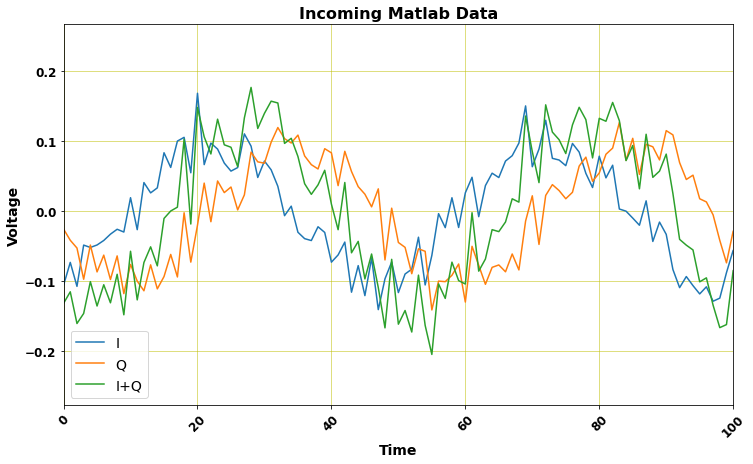

In [9]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(featuresDF.at[showFig, 'inPhase'] + featuresDF.at[showFig, 'quadrature'])
plt.legend(['I', 'Q', 'I+Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


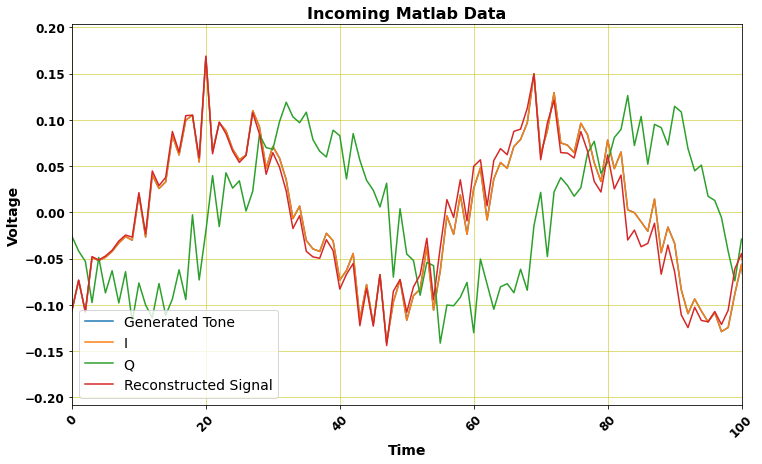

In [10]:
print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(12,7))
plt.plot(featuresDF.at[showFig, 'signal'])
plt.plot(featuresDF.at[showFig, 'inPhase'])
plt.plot(featuresDF.at[showFig, 'quadrature'])
plt.plot(iq_sig)
plt.legend(['Generated Tone', 'I', 'Q', 'Reconstructed Signal'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

Signal Frequency: 4000000.0
Signal Amplitude: 0.1
Signal Phase:     70.0


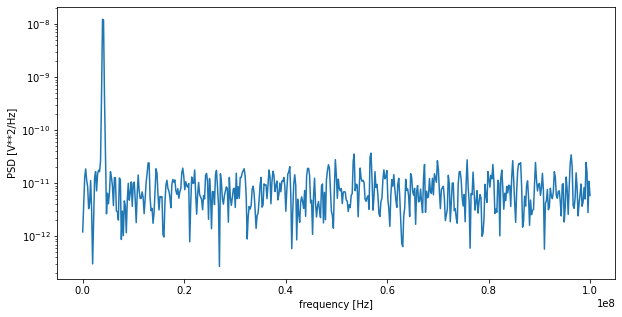

In [11]:
f, Pxx_den = welch(featuresDF.at[showFig,'signal'], fs, nperseg=1024)

print("Signal Frequency: {}".format(featuresDF.at[showFig,'frequency']))
print("Signal Amplitude: {}".format(featuresDF.at[showFig,'amplitude']))
print("Signal Phase:     {}".format(featuresDF.at[showFig,'phase']))
plt.figure(figsize=(10,5))
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshape data
signal_df_r = featuresDF
signal_df_r['iq'] = ''
for ii in range(0, len(signal_df_r)):
    signal_sample = signal_df_r.at[ii,'signal']
    i_sample = signal_df_r.at[ii,'inPhase']
    q_sample = signal_df_r.at[ii,'quadrature']

    # Normalize the dataset
    signal_sample = np.asarray(signal_sample).reshape(-1,1)
    i_sample = np.asarray(i_sample).reshape(-1,1)
    q_sample = np.asarray(q_sample).reshape(-1,1)

    signal_sample = scaler.fit_transform(signal_sample)
    #i_sample = scaler.fit_transform(i_sample)
    #q_sample = scaler.fit_transform(q_sample)

    #signal_sample = signal_sample.reshape(width, height, 1)
    #signal_sample = signal_sample.reshape(50, 40, 1)
    signal_df_r.at[ii,'signal'] = np.array(signal_sample).squeeze()

    iq_sample = np.concatenate([i_sample, q_sample], axis=1)

    #iq_sample = signal_sample.reshape((iq_sample.shape[0], iq_sample.shape[1], 1))
    iq_sample = np.expand_dims(iq_sample, 2)
    signal_df_r.at[ii,'iq'] = np.array(iq_sample)

In [13]:
print(signal_df_r.shape)
print(signal_df_r.at[showFig,'iq'].shape)
print(signal_df_r.at[showFig,'signal'].shape)

(14000, 9)
(2000, 2, 1)
(2000,)


In [14]:
#Split the dataset 
from sklearn.model_selection import train_test_split 
train_df, test_validation_df = train_test_split(signal_df_r, train_size=0.8, test_size=0.2, random_state = 42, shuffle=True)
valid_df, test_df = train_test_split(test_validation_df, train_size=0.5, test_size=0.5, random_state = 42, shuffle=True)
print("Shape of train inputs {}, train target {}".format(train_df['signal'].iloc[0].shape, train_df.shape))
print("Shape of validation inputs {}, validation target {}".format(valid_df['signal'].iloc[0].shape, valid_df.shape))
print("Shape of test inputs {}, test target {}".format(test_df['signal'].iloc[0].shape, test_df.shape))

Shape of train inputs (2000,), train target (11200, 9)
Shape of validation inputs (2000,), validation target (1400, 9)
Shape of test inputs (2000,), test target (1400, 9)


In [15]:
train_features = np.array(train_df.iq.to_list()).squeeze()
valid_features = np.array(valid_df.iq.to_list()).squeeze()
test_features = np.array(test_df.iq.to_list()).squeeze()

train_labels = np.array(train_df.amplitude.to_list())
valid_labels = np.array(valid_df.amplitude.to_list())
test_labels = np.array(test_df.amplitude.to_list())

In [16]:
print(train_features.shape)
print(train_labels.shape)

(11200, 2000, 2)
(11200,)


for ii in range(len(train_labels)):
    print(f"Index: {ii} | Amp Val: {train_labels[ii]}")

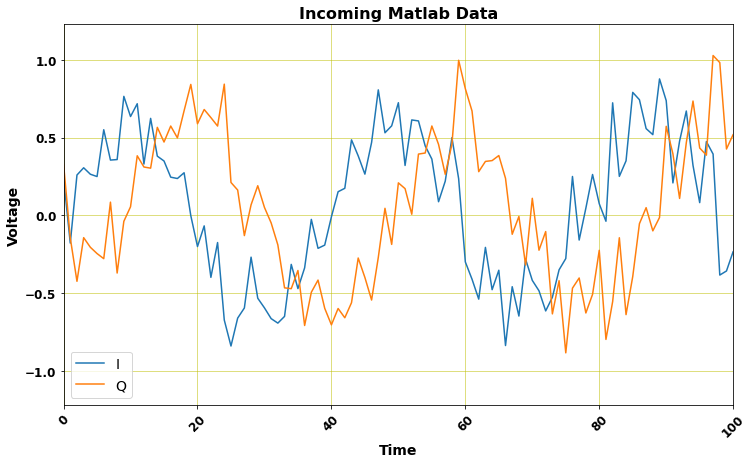

In [17]:
plt.figure(figsize=(12,7))
plt.plot(train_features[showFig,:,0]) #inPhase
plt.plot(train_features[showFig,:,1]) #quadrature
plt.legend(['I', 'Q'], loc='lower left', prop={'size': 14})
plt.title('Incoming Matlab Data', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Voltage', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)
plt.xlim(0,100)
plt.show()

In [37]:
#Import TensorFlow Libraries
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, \
                                    ReLU, LeakyReLU, Flatten, LSTM, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

#ADDED CONFIG OPTIONS FOR STABILTY
#TensorFlow allocating all of the GPU memory 
#to itself when it initialises the session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
#Reset Default graph - Needed only for Jupyter Notebook
tf.compat.v1.reset_default_graph()
tf.compat.v1.set_random_seed(42)

In [38]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [39]:
# Model configuration
batch_size = 1024
no_epochs = 300
verbosity = 1

In [54]:
modelType = "DNN"
modelName = "nanoConvPaper_v3.2.5_amp_HP"
#logDir = "logging" + "\\" + modelType + "\\" + modelName

In [55]:
glorotnormal = tf.keras.initializers.GlorotNormal()
zeros = tf.keras.initializers.Zeros()
truncatednormal = tf.keras.initializers.TruncatedNormal()
henormal = tf.keras.initializers.HeNormal()

In [56]:
#The hyperparameters & their values to be tested are stored in aspecial type called HParam
HP_INITIALIZER_1 = hp.HParam('initializer_1', hp.Discrete(['GlorotNormal', 'Zeros', 'TruncatedNormal', 'HeNormal']))
HP_L2REGULARIZERS_1 = hp.HParam('l2regularizer_1', hp.Discrete([0.01, 0.001, 0.0001]))
#HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([2, 3, 10]))
#HP_NUM_UNITS_3 = hp.HParam('num_units_3', hp.Discrete([2, 3, 10]))
#HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.3))
#HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['sgd', 'adam', 'nadam']))

#Settinf the Metric to RMSE
METRIC_RMSE = 'RootMeanSquaredError'

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logDir = "logging" + "\\" + modelType + "\\" + modelName
hp_logDir = logDir + "\\" + "hparam_tuning_" + timestamp
modelDir = "models" + "\\" + modelType + "\\" + modelName
hp_modelDir = modelDir + "\\" + "hparam_tuning_" + timestamp

#Creating & configuring log files
with tf.summary.create_file_writer(hp_logDir).as_default():
    hp.hparams_config(
        hparams=[HP_INITIALIZER_1, HP_L2REGULARIZERS_1],
        metrics=[hp.Metric(METRIC_RMSE, display_name='RMSE')]
    )

In [60]:
#A function that trains and validates the model and returns the rmse
def train_test_model(modelLogging, modelSaveFile, hparams):
    #Keras sequential model with Hyperparameters passed from the argument
    model = Sequential([
        
        #Initialize model
        #initializer = tf.keras.initializers.GlorotUniform()
        #regulizer = tf.keras.regularizers.l2(l2=0.01)

        #Add Layers
        InputLayer(input_shape=(2000,2)),

        LSTM(1, return_sequences=True),
        Flatten(),
        #Dropout(0.5),

        Dense(3, kernel_initializer=hparams[HP_INITIALIZER_1], kernel_regularizer=tf.keras.regularizers.l2(l2=hparams[HP_L2REGULARIZERS_1])),
        LeakyReLU(),
        #Dropout(0.5),
        Dense(2, kernel_initializer=hparams[HP_INITIALIZER_1], kernel_regularizer=tf.keras.regularizers.l2(l2=hparams[HP_L2REGULARIZERS_1])),
        LeakyReLU(),
        #Dropout(0.25),
        Dense(2, kernel_initializer=hparams[HP_INITIALIZER_1], kernel_regularizer=tf.keras.regularizers.l2(l2=hparams[HP_L2REGULARIZERS_1])),
        LeakyReLU(),
        #Flatten(),

        Dense(1, activation=None, name='amp_extract')

    ])

    model.summary()
    #plot_model(model)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

    model.compile(
            optimizer=optimizer, 
            loss='mse',
            metrics=['RootMeanSquaredError'],
            )

    es = EarlyStopping(monitor='val_root_mean_squared_error', #do not change
                    mode='min',  #do not change
                    min_delta=.0001,
                    verbose=1, # allows you to see more info per epoch
                    patience=25) # **** patience is how many validations to wait with nothing learned (patience * validation_freq)

    mc = ModelCheckpoint(modelSaveFile, 
                        monitor='val_root_mean_squared_error', 
                        mode='min', 
                        verbose=1, 
                        save_best_only=True)

    #Setup Logging
    #logDir = "logging" + "\\" + modelType + "\\" + modelName + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard = TensorBoard(log_dir=modelLogging)

    #Train the model
    startTime = datetime.now().timestamp()
    model.fit(
        train_features, train_labels,
        validation_data=(valid_features, valid_labels),
        epochs=no_epochs,
        callbacks=[tensorboard, es, mc],
        batch_size=batch_size,
        shuffle=True,
        verbose=verbosity
        )
    executionTime = (datetime.now().timestamp() - startTime)
    print(f"Training took {timedelta(seconds=executionTime)}")

    #Evaluate the Model
    _, rmse = model.evaluate(test_features, test_labels)
    return rmse

In [61]:
#A function to log the training process
def run(run_dir, run_model_save, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  
        rmse = train_test_model(run_dir, run_model_save, hparams)
        tf.summary.scalar(METRIC_RMSE, rmse, step=10)

In [62]:
#A unique number for each training session
session_num = 0

#Nested for loop training with all possible  combinathon of hyperparameters
for initializer in HP_INITIALIZER_1.domain.values:
    for regularizer in HP_L2REGULARIZERS_1.domain.values:
        hparams = {
            HP_INITIALIZER_1: initializer,
            HP_L2REGULARIZERS_1: regularizer,
        }
        run_name = "run-%d" % session_num
        runLoggingDir = hp_logDir + "\\" + run_name
        runModelSave = hp_modelDir + "\\" + run_name + '.h5'
        print('--- Starting trial: %s' % run_name)
        print({h.name: hparams[h] for h in hparams})
        run(runLoggingDir, runModelSave, hparams)
        session_num += 1

--- Starting trial: run-0
{'initializer_1': 'GlorotNormal', 'l2regularizer_1': 0.0001}
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 2000, 1)           16        
_________________________________________________________________
flatten_3 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6003      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 8         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 2)                 0         
___________________________________